In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import sys
sys.path.append('..')
import scipy.stats as stats    
import enum
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from math import dist
from distfit import distfit 

import consts
importlib.reload(consts)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

# pd set seed
np.random.seed(42)

In [2]:
df = pd.read_csv('..\processed\inputevents_decision_only.csv')


In [3]:
icustays_filtered = pd.read_csv("..\\filtered\\filtered_icustays.csv")
inputevents = df.merge(icustays_filtered[["stay_id", "first_careunit"]], left_on="stay_id", right_on="stay_id")
inputevents_SICU_MICU = inputevents[inputevents["first_careunit"].isin([consts.MICU, consts.SICU])]
inputevents_SICU_MICU = inputevents_SICU_MICU.rename(columns={"first_careunit":"unit"})

In [4]:
def generate_equal_size_group(group):
    smaller_size = group["unit"].value_counts().min()
    smaller_gr = group["unit"].value_counts().index[group.unit.value_counts().argmin()]
    bigger_gr = group["unit"].value_counts().index[group.unit.value_counts().argmax()]
    subgroup1 = group[group["unit"] == smaller_gr]
    subgroup2 = group[group["unit"] == bigger_gr].sample(smaller_size, random_state=42)
    return pd.concat([subgroup1, subgroup2], axis=0)

def get_bp_sections(all_events_df):
    bp_sections = []
    for i, bp_range in enumerate(consts.BP_RANGES):
        bp_low, bp_high = bp_range 
        bp_section = inputevents_SICU_MICU[(inputevents_SICU_MICU["bp_val"] >= bp_low) & 
                                    (inputevents_SICU_MICU["bp_val"] <= bp_high) & 
                                    (inputevents_SICU_MICU["originalrate"] <= consts.MAXIMAL_ORIGINALRATE) & 
                                    (inputevents_SICU_MICU["originalrate"] >= consts.MINIMAL_ORIGINALRATE)]
        bp_section = generate_equal_size_group(bp_section)
        bp_sections.append(bp_section)
    return bp_sections

In [5]:
def plot_signle_plot(data, distribution, ax, bp_group):
    # find out number of samples per group
    number_of_samples = data.shape[0]/2
    #plot histogram
    sns.histplot(data=data[["originalrate", "unit"]],
                x="originalrate",
                bins=12, 
                binrange = (consts.MINIMAL_ORIGINALRATE,consts.MAXIMAL_ORIGINALRATE),
                hue="unit", 
                #kde=True, 
                stat="density",
                ax=ax,
                kde=True,
                palette={consts.SICU : "red", consts.MICU : "black"},
                alpha=0.2)
    # plot the mle curve for selected distribution
    MICU_data = data[data["unit"] == consts.MICU]["originalrate"]
    SICU_data = data[data["unit"] == consts.SICU]["originalrate"]
    # apply kolmogorov smirnov test
    ks = stats.kstest(MICU_data, SICU_data)
    ks = stats.ks_2samp(MICU_data, SICU_data)
    # add title per BP group
    bp_low, bp_high = consts.BP_RANGES[bp_group][0], consts.BP_RANGES[bp_group][1]
    ax.set_title(f"BP: {bp_low}-{bp_high} \n {number_of_samples} samples per group \n kolomogorov smirnov p-val: {ks[1]:.4f} ", fontsize=14)
    ax.legend(labels=["MICU","SICU"])

def plot_all_groups(data, distribution):
    # set graph settings
    fig, axs = plt.subplots(4, 2)
    fig.set_size_inches(16, 16)
    fig.suptitle('Doses histogram per BP range group', fontsize=24)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.92, 
                        wspace=0.5, 
                        hspace=0.5)
    # get data separeted to BP sections
    bp_sections = get_bp_sections(data)
    # plot graph per section
    for i, bp_section in enumerate(bp_sections):
        plot_signle_plot(bp_section, distribution, axs[i//2, i%2], i)
    # show graph
    plt.show()

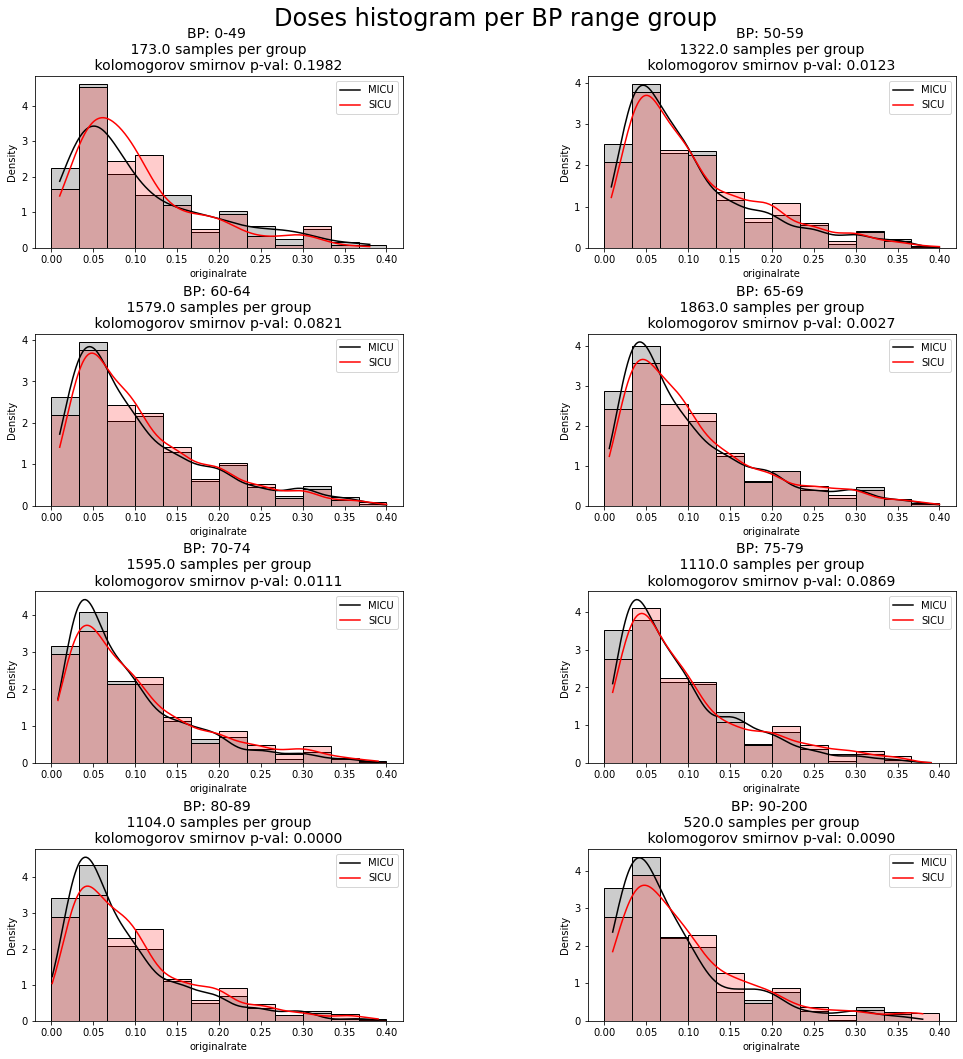

In [6]:
import enum
import seaborn as sns
import matplotlib.pyplot as plt

# please ignore the distribution parameter, its is legacy from another version of this notebook that fitted the best curve
# before ploting. In the next version there is only KDE plot
plot_all_groups(inputevents_SICU_MICU, "lognorm")
plt.show()